In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import clone
import warnings


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (GridSearchCV, 
                                    train_test_split, KFold, 
                                    cross_val_score)

import rfpimp as rf
from tqdm import tqdm

from pyod.models.lof import LOF

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

# Кратко о представленной задаче #

Данная учебная задача была текущей аттестацией на курсе "Практический Machine Learning". 
Она представляет собой классическую задачу бинарной классификации, где необходимо было определить, является ли опухоль доброкачественной (0) или злокачественной (1).
Задача представлялась как закрытый хакатон на базе kaggle для студентов курса. Оценочным критерием принимался F1-score.
Мой результат занял 1-2 (одинаковое качество у первых двух мест) с показателем f1 = 0.97543 (скриншот в архиве).

## Подготавливаем тренировочный ДатаСет ##

In [5]:
# Данные для обучения разделены на 5 файлов, ключом между которыми является столбец 'ID'

# Подготовим адрес к соответствующим файлам
location_train = r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\train'
df_train_list = [r'\train0.csv', r'\train1.csv', r'\train2.csv', r'\train3.csv', r'\train4.csv']

# Проверим заголовки столбцов
for item in df_train_list:
    df_train_n = pd.read_csv(location_train + item)
    print(df_train_n.columns.values)
    print('-' * 30)

['ID' 'Category' 'radius_mean' 'radius_std' 'radius_max' 'texture_mean'
 'texture_std']
------------------------------
['IT' 'Category' 'area_std' 'area_max' 'smoothness_mean' 'smoothness_std'
 'smoothness_max' 'compactness_mean' 'compactness_std' 'compactness_max'
 'concavity_mean' 'concavity_std' 'concavity_max']
------------------------------
['ID' 'Category' 'concave_points_mean' 'concave_points_std'
 'concave_points_max' 'symmetry_mean' 'symmetry_std' 'symmetry_max']
------------------------------
['1D' 'Category' 'texture_max' 'perimeter_mean' 'perimeter_std'
 'perimeter_max' 'area_mean']
------------------------------
['ID' 'Category' 'fractal_dimension_mean' 'fractal_dimension_std'
 'fractal_dimension_max']
------------------------------


In [7]:
# Видно, что есть 2 проблемы: 
# 1) Ошибки в заголовке 'ID' (первый в списке)
# 2) Повторение лейблов (Category) в каждом из 5 файлов

# Исправляем первую проблему
# Приводим все возможные вариации 'ID' к единому виду

meta_dataframe = [None] * len(df_train_list)
for n, item in enumerate(df_train_list):
    meta_dataframe[n] = pd.read_csv(location_train + item) 
    meta_dataframe[n].rename(columns={meta_dataframe[n].columns[0]: 'ID'}, inplace=True) # Т.к. ID - всегда первая колонка, переименуем ее через 'columns[0]'

In [8]:
# Исправляем вторую проблему:
    
y_train = meta_dataframe[0]['Category'] # Извлекаем столбец лейблов

# Удаляем 'Category' из каждого тренировочного ДатаСета
for n in range(len(df_train_list)):
    meta_dataframe[n].drop('Category', axis=1, inplace=True)

# Теперь объединим все тренировочные ДатаСеты в один; ключом будет 'ID'
X_train = meta_dataframe[0]
for n in range(1,len(df_train_list)):
    X_train = pd.merge(X_train, meta_dataframe[n], on='ID', how='left')

## Подготавливаем тестовый ДатаСет ##

In [9]:
# Он также состоит из 5 файлов.
location_test = r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\test'
df_train_list = [r'\test0.csv', r'\test1.csv', r'\test2.csv', r'\test3.csv', r'\test4.csv']

# Т.к. заголовки в порядке, сразу объединим все тестовые ДатаСеты в один; ключом будет 'ID'
X_test_raw = pd.read_csv(location_test + r'\test0.csv')
for df in df_train_list[1:]:
    X_test_raw = pd.merge(X_test_raw, pd.read_csv(location_test + df) , on='ID', how='left')

In [10]:
# Сравним наименования колонок в тренировочном и тестовом ДатаСетах:

print(X_train.columns.values)
print(f'{X_test_raw.columns.values} \n')

['ID' 'radius_mean' 'radius_std' 'radius_max' 'texture_mean' 'texture_std'
 'area_std' 'area_max' 'smoothness_mean' 'smoothness_std' 'smoothness_max'
 'compactness_mean' 'compactness_std' 'compactness_max' 'concavity_mean'
 'concavity_std' 'concavity_max' 'concave_points_mean'
 'concave_points_std' 'concave_points_max' 'symmetry_mean' 'symmetry_std'
 'symmetry_max' 'texture_max' 'perimeter_mean' 'perimeter_std'
 'perimeter_max' 'area_mean' 'fractal_dimension_mean'
 'fractal_dimension_std' 'fractal_dimension_max']
['ID' 'radius_mean' 'radius_std' 'radius_max' 'texture_mean' 'texture_std'
 'fractal_dimension_mean' 'fractal_dimension_std' 'fractal_dimension_max'
 'conc_points_mean' 'conc_points_std' 'conc_points_max' 'symmetry_mean'
 'symmetry_std' 'symmetry_max' 'area_std' 'area_max' 'smoothness_mean'
 'smoothness_std' 'smoothness_max' 'compactness_mean' 'compactness_std'
 'compactness_max' 'concavity_mean' 'concavity_std' 'concavity_max'
 'texture_max' 'p_mean' 'p_std' 'p_max' 'area_mea

Некоторые наименования отличаются, также отличается порядок признаков. Это недопустимо, т.к. из тестовой выборки не удастся удалить скоррелированные фичи по имени, а также произвести нормализацию с помощью обученного на тренировочном сете скейлера. Необходимо исправить.

In [11]:
# 1) Переименуем признаки тестовой выборки, чтобы они соответствовали тренировочной

renamer = {'conc_points_mean':'concave_points_mean',
           'conc_points_std':'concave_points_std',
           'conc_points_max':'concave_points_max',
           'p_mean':'perimeter_mean',
           'p_std':'perimeter_std',
           'p_max':'perimeter_max'}

X_test_raw.rename(columns=renamer, inplace=True)

In [12]:
X_test_raw.head(2) # Проверим

,ID,radius_mean,radius_std,radius_max,texture_mean,texture_std,fractal_dimension_mean,fractal_dimension_std,fractal_dimension_max,concave_points_mean,...,compactness_std,compactness_max,concavity_mean,concavity_std,concavity_max,texture_max,perimeter_mean,perimeter_std,perimeter_max,area_mean
0,8915,14.96,19.10,97.03,687.3,0.08992,0.14890,0.2962,0.08472,26.19,...,0.01536,0.011870,0.01522,0.002815,16.25,0.09823,0.05940,0.04819,0.1879,0.05852
1,91376702,17.85,13.23,114.60,992.1,0.07838,0.08341,0.1783,0.05871,18.42,...,0.01153,0.007437,0.01302,0.001309,19.82,0.06217,0.04445,0.04178,0.1220,0.05243


In [13]:
# 2) Упорядочим по аналогии с тренировочным ДатаСетом
new_order = X_train.columns.values

X_test = X_test_raw[new_order]

In [14]:
# Проверим. Видим, что все в порядке

print(X_train.columns.values)
print(X_test.columns.values)

['ID' 'radius_mean' 'radius_std' 'radius_max' 'texture_mean' 'texture_std'
 'area_std' 'area_max' 'smoothness_mean' 'smoothness_std' 'smoothness_max'
 'compactness_mean' 'compactness_std' 'compactness_max' 'concavity_mean'
 'concavity_std' 'concavity_max' 'concave_points_mean'
 'concave_points_std' 'concave_points_max' 'symmetry_mean' 'symmetry_std'
 'symmetry_max' 'texture_max' 'perimeter_mean' 'perimeter_std'
 'perimeter_max' 'area_mean' 'fractal_dimension_mean'
 'fractal_dimension_std' 'fractal_dimension_max']
['ID' 'radius_mean' 'radius_std' 'radius_max' 'texture_mean' 'texture_std'
 'area_std' 'area_max' 'smoothness_mean' 'smoothness_std' 'smoothness_max'
 'compactness_mean' 'compactness_std' 'compactness_max' 'concavity_mean'
 'concavity_std' 'concavity_max' 'concave_points_mean'
 'concave_points_std' 'concave_points_max' 'symmetry_mean' 'symmetry_std'
 'symmetry_max' 'texture_max' 'perimeter_mean' 'perimeter_std'
 'perimeter_max' 'area_mean' 'fractal_dimension_mean'
 'fractal_di

In [15]:
print(X_train.isna().sum(), '\n') # Проверяем, есть ли пропуски в тренировочном сете. Пропусков нет
print(y_train.isna().sum())

ID                        0
radius_mean               0
radius_std                0
radius_max                0
texture_mean              0
texture_std               0
area_std                  0
area_max                  0
smoothness_mean           0
smoothness_std            0
smoothness_max            0
compactness_mean          0
compactness_std           0
compactness_max           0
concavity_mean            0
concavity_std             0
concavity_max             0
concave_points_mean       0
concave_points_std        0
concave_points_max        0
symmetry_mean             0
symmetry_std              0
symmetry_max              0
texture_max               0
perimeter_mean            0
perimeter_std             0
perimeter_max             0
area_mean                 0
fractal_dimension_mean    0
fractal_dimension_std     0
fractal_dimension_max     0
dtype: int64 

0


In [16]:
X_train.info() # Категориальных и нулевых признаков нет

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 0 to 283
Data columns (total 31 columns):
ID                        284 non-null int64
radius_mean               284 non-null float64
radius_std                284 non-null float64
radius_max                284 non-null float64
texture_mean              284 non-null float64
texture_std               284 non-null float64
area_std                  284 non-null float64
area_max                  284 non-null float64
smoothness_mean           284 non-null float64
smoothness_std            284 non-null float64
smoothness_max            284 non-null float64
compactness_mean          284 non-null float64
compactness_std           284 non-null float64
compactness_max           284 non-null float64
concavity_mean            284 non-null float64
concavity_std             284 non-null float64
concavity_max             284 non-null float64
concave_points_mean       284 non-null float64
concave_points_std        284 non-null float64
conc

In [17]:
# Теперь уберем столбец 'ID' из тренировочного сета, т.к. он неинформативен для обучения
X_train.drop('ID', axis=1, inplace=True)

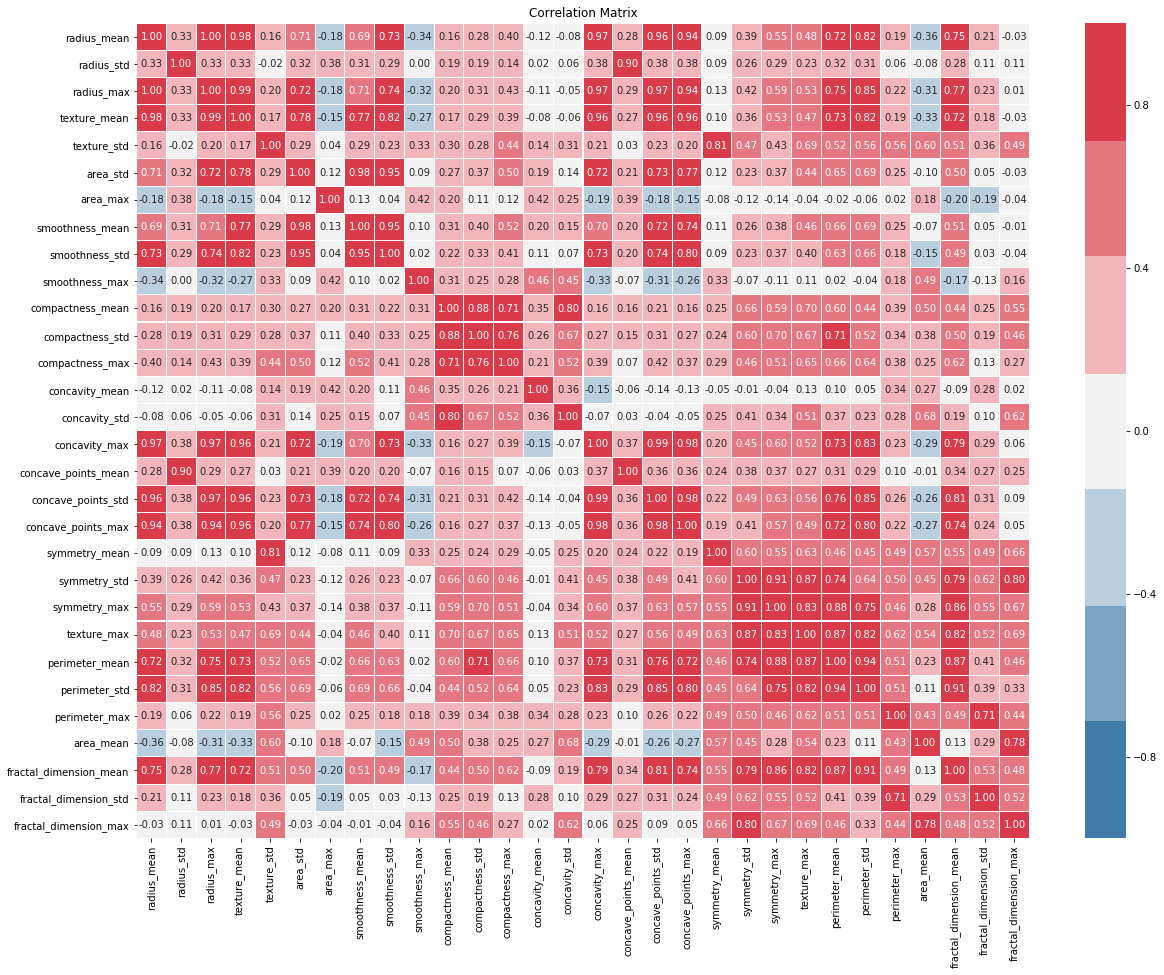

In [37]:
# Проверяем корреляцию между признаками c помощью теплокарты

correlation = X_train.corr()

fig, ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(h_neg=240, h_pos=9, n=7, center='light')
htm = sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, fmt='.2f',center=0,cmap=cmap, linewidths=.1, ax=ax)
htm.set_title('Correlation Matrix', fontsize=12, fontdict={})
htm

### После анализа теплокарты видим, что значительная часть признаков сильно скоррелированы между собой. Т.к. при обучении такие признаки могут ухудшить качество модели, необходимо от них избавиться ###

In [42]:
# Определим список признаков, которые наиболее скоррелированы. В качестве порога возьмем коэффициент корреляции Пирсона > 0.93

cor_feature_names = []
for i in correlation:
    for j in correlation.index[correlation[i] > 0.93]:
        if i != j and j not in cor_feature_names and i not in cor_feature_names:
            cor_feature_names.append(j)
            print(f'{i} --> {j}: coef = {correlation[i][correlation.index==j].values[0]:.5f}') # вывод высокоскоррелированных признаков

radius_mean --> radius_max: coef = 0.99825
radius_mean --> texture_mean: coef = 0.98487
radius_mean --> concavity_max: coef = 0.96833
radius_mean --> concave_points_std: coef = 0.96500
radius_mean --> concave_points_max: coef = 0.93573
area_std --> smoothness_mean: coef = 0.98326
area_std --> smoothness_std: coef = 0.95475
perimeter_mean --> perimeter_std: coef = 0.93746


In [43]:
# Удаляем признаки с высокой корреляцией

drop_feature_names = cor_feature_names # список "грязных" фич с высокой корреляцией. Он понадобиться для предобработки X_test
X_train = X_train.drop(drop_feature_names, axis=1)

# Поиск выбросов #

Идея избавиться от выбросов пришла в голову после визуализации данных по результатам оценки важности признаков. Там бросились в глаза отдельные точки (шум), попадающие в чужой класс, которые могут негативно отразиться на обучении. Также, очевидно, что классы несколько несбалансированы. И хоть дисбаланс является минимальным, удаляя выбросы можно это учесть. Так допустимо сделать еще и потому, что в реальной жизни при решении таких задач ошибки второго рода (пропуск рака) опаснее ошибок первого рода (ложная тревога). Однако сейчас удаление выбросов по логике стоит ДО оценки важности признаков, т.к. данная процедура может повысить качество обучение RandomForest, с помощью которого оценивается feature importances. 

Выбросы будем искать методом LOF для каждого класса отдельно

In [44]:
clf_lof = LOF(contamination=0.07) # 7,5% самых экстримальных семплов среди отицательных диагнозов считать выбросами
clf_lof.fit(X_train[y_train == 0])
y_train0_out_pred = clf_lof.labels_

clf_lof = LOF(contamination=0.05) # 5% самых экстримальных семплов среди положительных диагнозов считать выбросами
clf_lof.fit(X_train[y_train == 1])
y_train1_out_pred = clf_lof.labels_

In [46]:
# Объединим 2 списка предсказаний в один в соответствии с индексами основного ДатаСета

outliers_list = np.zeros(X_train.shape[0], dtype=int)
outliers_list[y_train == 0] = y_train0_out_pred
outliers_list[y_train == 1] = y_train1_out_pred

np.bincount(outliers_list) # Получилось суммарно 19 выбросов

array([265,  19], dtype=int64)

In [47]:
# Избавляемся от выбросов

X_train.drop(np.where(outliers_list == 1)[0], axis=0, inplace=True)
y_train.drop(np.where(outliers_list == 1)[0], axis=0,  inplace=True)

## Нормализуем признаки ##

In [49]:
feature_names = X_train.columns.values

In [50]:
std_scaler = StandardScaler()
X_train_norm = std_scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=feature_names)

## Произведем подсчет features importances ##

Слабые признаки могут будут "зашумлять" модель при обучении.
Также их анализ увеличит объем ресурсов, требуемых для обработки

От таких признаком можно будет избавиться

In [51]:
# Обучаем случайный лес. Извините, что не описываю, как подбирались гиперпараметры, более подробно
# Это был обычный GridSearch с кучей разных параметров и кучей итераций повторения

rfc = RandomForestClassifier(max_depth=7, n_estimators=300) 

print(cross_val_score(rfc, X_train_norm, y_train, cv=6, scoring='accuracy'))
print(np.mean(cross_val_score(rfc, X_train_norm, y_train, cv=6, scoring='accuracy')))

[1.         0.88888889 0.91111111 0.95454545 0.95348837 1.        ]
0.9512547960222378


### Проверяем важность признаков через собственный атрибут RandomForest ###

In [52]:
rfc.fit(X_train_norm, y_train)
imp_res1 = pd.DataFrame({
        'feature': feature_names[np.argsort(-rfc.feature_importances_)],
       'num_of_feature': np.argsort(-rfc.feature_importances_),
        'importance': -np.sort(-rfc.feature_importances_)})
imp_res1

,feature,num_of_feature,importance
0,fractal_dimension_mean,19,0.230138
1,radius_mean,0,0.158555
2,perimeter_mean,16,0.129569
3,symmetry_max,14,0.092242
4,area_std,3,0.081540
5,texture_max,15,0.052274
6,concave_points_mean,11,0.043671
7,radius_std,1,0.032088
8,symmetry_std,13,0.031980
9,fractal_dimension_std,20,0.021198


### Существует мнение, что собственный способ оценки важностей фич RandomForest не всего отображает значения корректно ### 
https://explained.ai/rf-importance/index.html

Поэтому воспользуемся вторым методом расчета - permutation feature importances из библиотеки rf-pimp, который оценивает важности через перестановку столбцов и последующую повторную оценку acurracy score.

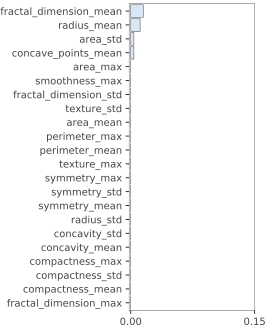

In [53]:
# Проверяем важность признаков с помощью библиотеки rf-pimp

imp_res2 = rf.importances(rfc, X_train_norm, y_train) # Расчет permutation feature importances для RandomForestClassifier
rf.plot_importances(imp_res2) # Отображение

Как видим, +/- расклад важности признаков стандартного метода и метода permutation совпадает

In [54]:
# От некоторых наименее информативных признаков можно избавиться, но не будем сильно наглеть

drop_feature_names2 = [
                       'fractal_dimension_max', 
                      # 'texture_std',
                       'area_max',
                       'compactness_mean',
                       ]

X_train_norm = X_train_norm.drop(drop_feature_names2, axis=1)
feature_names = X_train_norm.columns.values

In [55]:
# Проверим важность еще раз
rfc.fit(X_train_norm, y_train)
imp_res1 = pd.DataFrame({
        'feature': feature_names[np.argsort(-rfc.feature_importances_)],
       'num_of_feature': np.argsort(-rfc.feature_importances_),
        'importance': -np.sort(-rfc.feature_importances_)})
imp_res1 # Порядок не изменился значительно

,feature,num_of_feature,importance
0,fractal_dimension_mean,17,0.235978
1,radius_mean,0,0.143344
2,perimeter_mean,14,0.128327
3,area_std,3,0.112212
4,symmetry_max,12,0.110028
5,concave_points_mean,9,0.041165
6,symmetry_std,11,0.038525
7,radius_std,1,0.036314
8,texture_max,13,0.035504
9,fractal_dimension_std,18,0.025745


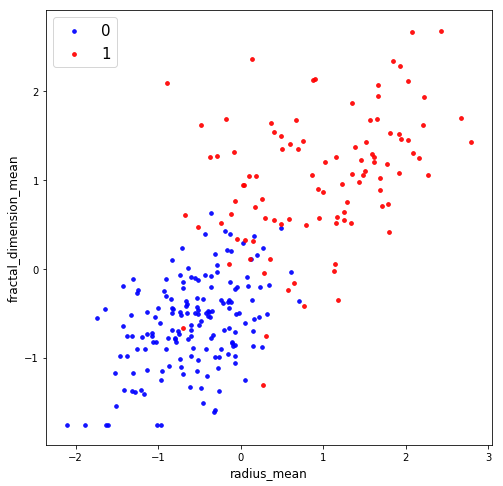

In [57]:
# Визуализируем отношения между двумя наиболее важными признаками

x = 0
y = 17

plt.figure(figsize=(8.0, 8.0))
plt.xlabel(feature_names[x],fontsize=12)
plt.ylabel(feature_names[y],fontsize=12)

category_0 = plt.scatter(X_train_norm.iloc[:, x][y_train.values == 0], X_train_norm.iloc[:, y][y_train.values == 0], c='blue', s=13, alpha=0.90)
category_1 = plt.scatter(X_train_norm.iloc[:, x][y_train.values == 1], X_train_norm.iloc[:, y][y_train.values == 1], c='red', s=14, alpha=0.90)

plt.legend((category_0, category_1), ('0', '1'), fontsize=15)

На данном этапе видно, что данные практически линейно разделимы. Вероятно, логистическая регрессия и опорные вектора покажут наилучшее качество. Но т.к. мы хотим наилучшего качество, будем далее осуществлять стекинг линейной регрессии с другими методами.

In [58]:
# Функция предобработки тестовой выборки, повторяющая шаги предобработки тренировочной

def prep_test(X):
    X_test_w = X.copy()
    X_test_w.drop('ID', axis=1, inplace=True)
    X_test_w.drop(cor_feature_names, axis=1, inplace=True)
    X_test_norm = std_scaler.transform(X_test_w)
    X_test_norm = pd.DataFrame(X_test_norm, columns=X_test_w.columns.values)
    X_test_norm = X_test_norm.drop(drop_feature_names2, axis=1)
    
    return X_test_norm

X_test_norm = prep_test(X_test)

In [59]:
cv = KFold(n_splits=3, shuffle=True) # готовим фолды для работы стекинга.

In [60]:
# Функция для расчета мета-данных для мета-алгоритма. Парметр predict нужен для того, чтобы выбирать, 
# уравнивать ли результаты базовых классификаторов, обученных на разных фолдах,  для создания тестовых мета-данных
# или просто 1 раз обучить базовый алгоритм на всем X-test

def compute_meta_feature(clf, X_train, X_test, y_train, cv, predict):

    if predict:
        X_meta_test = np.zeros(shape=(X_test.shape[0]), dtype=np.float32)
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        if predict:
            X_meta_test = X_meta_test + folded_clf.predict_proba(X_test)[:, 1]
            X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
        else:
            X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]

    if predict:
        X_meta_test = X_meta_test/cv.get_n_splits()
        print('X_meta_test ready for predictions')
    
    else:
        meta_clf = clone(clf)
        meta_clf.fit(X_train, y_train)
        X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
        print('X_meta_test ready for validation')
    
    return X_meta_train, X_meta_test

In [63]:
def generate_metafeatures(classifiers, X_train, X_test, y_train, cv, predict=False):

    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv, predict)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test


Дальше идет кропотливая работа с разными алгоритмами и проверка того, какое качество они дают на разных сплитах

In [118]:
for n in [1, 2,3,4,5]:
    clf_tester = xgb.XGBClassifier(n_estimators=500, max_depth=n)
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n =', n)
    print(val_score)
    print(np.mean(val_score))

n = 1
[1.         0.94736842 0.88888889 1.         0.94736842 0.8
 1.         0.95238095 0.94736842 1.        ]
0.9483375104427736
n = 2
[1.         0.94736842 0.88888889 0.95238095 0.94736842 0.85714286
 1.         0.95238095 1.         1.        ]
0.9545530492898914
n = 3
[1.         0.94736842 0.88888889 0.95238095 0.88888889 0.85714286
 1.         0.9        1.         1.        ]
0.9434670008354219
n = 4
[1.         0.94736842 0.88888889 0.95238095 0.88888889 0.85714286
 1.         0.95238095 1.         1.        ]
0.9487050960735172
n = 5
[1.         0.94736842 0.88888889 0.95238095 0.88888889 0.85714286
 1.         0.9        1.         1.        ]
0.9434670008354219


In [43]:
for n in [80,90,100,150,200]:
    clf_tester = GradientBoostingClassifier(n_estimators=n, max_depth=3, max_features='sqrt')
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print('> ', np.mean(val_score))

n =  80
[1.         0.94736842 0.82352941 0.76190476 0.88888889 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9226202761806477
n =  90
[1.         0.94736842 0.82352941 0.81818182 0.94736842 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9340959350247277
n =  100
[0.95238095 0.94736842 0.88888889 0.7826087  0.94736842 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9323126657222767
n =  150
[1.         0.94736842 0.94736842 0.7826087  0.94736842 0.9
 1.         0.94736842 1.         1.        ]
>  0.94720823798627
n =  200
[1.         0.94736842 0.94736842 0.7826087  0.88888889 0.85714286
 1.         0.94736842 1.         1.        ]
>  0.9370745704841814


In [29]:
clf_tester = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=2000, class_weight='balanced_subsample')
val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
print(val_score)
print(np.mean(val_score))

[1.         0.94736842 1.         1.         0.94736842 0.84210526
 1.         0.94736842 1.         1.        ]
0.9684210526315791


In [38]:
for n in [1]:
    clf_tester = SVC(C=n, probability=True, gamma='scale')
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print(np.mean(val_score))

n =  1
[1.         1.         1.         0.94736842 0.85714286 0.84210526
 1.         0.94736842 1.         1.        ]
0.9593984962406015


In [39]:
for n in [3]:
    clf_tester = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100)
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print(np.mean(val_score))

n =  3
[1.         0.57142857 0.9        0.94736842 0.9        0.8
 1.         0.94736842 1.         1.        ]
0.9066165413533834


In [146]:
for n in [2,3,4,5,6,7,8]:
    clf_tester = ExtraTreesClassifier(max_depth=n, n_estimators=300, bootstrap=True, class_weight='balanced_subsample')
    val_score = cross_val_score(clf_tester, X_train_norm, y_train, cv=10, scoring='f1')
    print('n = ', n)
    print(val_score)
    print(np.mean(val_score))

n =  2
[0.95238095 0.94736842 0.75       0.73684211 1.         0.8
 1.         0.94736842 1.         1.        ]
0.9133959899749373
n =  3
[0.95238095 0.94736842 0.75       0.76190476 0.95238095 0.8
 1.         0.9        1.         1.        ]
0.9064035087719298
n =  4
[0.95238095 0.94736842 0.88888889 0.76190476 0.95238095 0.8
 1.         0.85714286 1.         1.        ]
0.9160066833751044
n =  5
[0.95238095 0.94736842 0.88888889 0.9        0.9        0.84210526
 1.         0.9        1.         1.        ]
0.9330743525480368
n =  6
[0.95238095 0.94736842 0.88888889 0.9        0.95238095 0.84210526
 1.         0.94736842 1.         1.        ]
0.9430492898913952
n =  7
[0.95238095 0.94736842 0.88888889 0.85714286 0.95238095 0.84210526
 1.         0.94736842 1.         1.        ]
0.9387635756056809
n =  8
[0.95238095 0.94736842 0.88888889 0.9        0.9        0.88888889
 1.         0.94736842 1.         1.        ]
0.9424895572263994


## Тест алгоритмов в стекинге ##

Далее тестируем алгоритмы в стекинге. Упор, конечно делается на линейные методы. Для воспроизводимости результатов я зафиксировал random_state при разделении train_test_split, чтобы проверять, какие связки алгоритмов показывают себя лучше. Также мы проверим, с какими параметрами регуляризации мета-алгоритм (также логистическая регрессия) показывают лучшие результаты.

In [65]:
list1 = []
list10 = []
list100 = []

for state in range(11):
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_norm, y_train, test_size=0.20, shuffle=True, random_state=state)

    warnings.filterwarnings('ignore')

    svс = SVC(C=1, probability=True, gamma='scale')
    rf = ExtraTreesClassifier(max_depth=n, n_estimators=300, bootstrap=True, class_weight='balanced_subsample')
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100)
    xg = xgb.XGBClassifier(n_estimators=500, max_depth=2)
    grad = GradientBoostingClassifier(n_estimators=150, max_depth=3, max_features='sqrt')
    lr = LogisticRegression(solver='lbfgs') # Дефолтная логистическая регрессия
    lrl2 = LogisticRegression(penalty='l2', C=0.4, class_weight='balanced', solver='lbfgs') # Логистическая регрессия с L2-регуляризацией и сбалансированностью классов, т.к. больных меньше, чем здоровых
    lrl1 = LogisticRegression(penalty='l1', C=1, class_weight='balanced')

    clf_array = [
                # svс, 
                # rf,                      
                 ada, # !
                # xg,
                # grad,
                # cat,
                # lr,                       
                 lrl2, # !
                # lrl1
                ]

    stacked_features_train, stacked_features_test = generate_metafeatures(clf_array, X_train_split.values, X_test_split.values, y_train_split.values, cv)
    print('random state = ', state)
    
    total_features_train = np.hstack([X_train_split, stacked_features_train])
    total_features_test = np.hstack([X_test_split, stacked_features_test])
    
    for n, c in enumerate([0.1, 1, 10, 100]):
        clf_meta = LogisticRegression(solver='lbfgs', penalty='l2', C=c)
        clf_meta.fit(stacked_features_train, y_train_split)
        y_pred = clf_meta.predict(stacked_features_test)
        f1 = f1_score(y_test_split, y_pred)
        if c == 1:
            list1.append(f1)
        if c == 10:
            list10.append(f1)
        if c == 100:
            list100.append(f1)
        print(f'{c}, f1 = {f1:.5f}')
print('C1 = ', np.mean(list1)) # Вывод значения коэффициента регуляризации для мета-алгоритма и усредненного значения F1-score при данном коэффициенте
print('C10 = ', np.mean(list10))
print('C100 = ', np.mean(list100))

  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.31it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


random state =  0
0.1, f1 = 1.00000
1, f1 = 1.00000
10, f1 = 0.97297
100, f1 = 0.97297


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.58it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


random state =  1
0.1, f1 = 0.90476
1, f1 = 0.90476
10, f1 = 0.90476
100, f1 = 0.90476


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.18it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


random state =  2
0.1, f1 = 0.94118
1, f1 = 0.96970
10, f1 = 0.96970
100, f1 = 0.96970


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.81it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


random state =  3
0.1, f1 = 0.97436
1, f1 = 0.97436
10, f1 = 0.97436
100, f1 = 1.00000


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.95it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


random state =  4
0.1, f1 = 0.94340
1, f1 = 0.94340
10, f1 = 0.94340
100, f1 = 0.94340


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.38it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


random state =  5
0.1, f1 = 0.91667
1, f1 = 0.96000
10, f1 = 0.96000
100, f1 = 0.98039


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.00it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


random state =  6
0.1, f1 = 0.95000
1, f1 = 0.97561
10, f1 = 0.95000
100, f1 = 0.92308


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.76it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


random state =  7
0.1, f1 = 0.95652
1, f1 = 0.95652
10, f1 = 0.95652
100, f1 = 0.97872


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.84it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


random state =  8
0.1, f1 = 0.96000
1, f1 = 0.96000
10, f1 = 0.96000
100, f1 = 0.98039


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  2.15it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


random state =  9
0.1, f1 = 0.96774
1, f1 = 0.96774
10, f1 = 0.96774
100, f1 = 0.96774


  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:00<00:00,  1.85it/s]

X_meta_test ready for validation


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


random state =  10
0.1, f1 = 0.96552
1, f1 = 1.00000
10, f1 = 1.00000
100, f1 = 1.00000
C1 =  0.9647352278131646
C10 =  0.9599500657109293
C100 =  0.9655595136716858


# РЕШЕНИЕ #

В нашем случае, наилучшее качество показывает логистическая регрессия с L2-регуляризацией в связе с AdaBoost. Похоже, что данные методы скомпенсировали слабости друг друга. Мета-алгоритм принимается с коэффициентом С = 100

In [64]:
sv = SVC(C=3, probability=True, gamma='scale')
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=200)
et = ExtraTreesClassifier(max_depth=9, n_estimators=400, bootstrap=True, class_weight='balanced_subsample')
xg = xgb.XGBClassifier(n_estimators=500, max_depth=2)
lr = LogisticRegression(solver='lbfgs') # Стандартная логистическая регрессия
lrl2 = LogisticRegression(penalty='l2', C=0.4, class_weight='balanced', solver='lbfgs') # Логистическая регрессия с L2-регуляризацией и сбалансированностью классов, т.к. больных меньше, чем здоровых

clf_array = [
            # sv,
            ada,
            # et,                      # !
            # xg,
            # lr,                       # !
             lrl2
            ]

stacked_features_train, stacked_features_test = generate_metafeatures(clf_array, X_train_norm.values, X_test_norm.values, y_train.values, cv=cv)

clf_meta = LogisticRegression(penalty='l2', C=100, solver='lbfgs')
clf_meta.fit(stacked_features_train, y_train)
y_pred = clf_meta.predict(stacked_features_test)

  0%|          | 0/2 [00:00<?, ?it/s]

X_meta_test ready for validation


 50%|█████     | 1/2 [00:01<00:01,  1.10s/it]

X_meta_test ready for validation


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Обработка результата. Формирование submission

In [57]:
y_pred = y_pred.astype(int)

In [58]:
submission = pd.DataFrame(y_pred, columns=['Category'], index=None)
subission_sample = pd.read_csv(filepath_or_buffer=r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\submission_sample.csv')
submission = pd.concat([subission_sample['ID'], submission], axis=1, sort=False)
submission.to_csv(path_or_buf=r'C:\Users\OlegD\Desktop\Machine Learning\mid-term hackaton\submission-ada+lr2-c100(2).csv', index=None)
submission.head()

,ID,Category
0,8915,0
1,91376702,0
2,8710441,0
3,871641,0
4,873592,1
